# Assignment 5: CNN on Cultural Image Data

__Multi-class classification of impressionist painters__

So far in class, we've been working with 'toy' datasets - handwriting, cats, dogs, and so on. However, this course is on the application of computer vision and deep learning to cultural data. This week, your assignment is to use what you've learned so far to build a classifier which can predict artists from paintings.

You can find the data for the assignment here: https://www.kaggle.com/delayedkarma/impressionist-classifier-data

Using this data, you should build a deep learning model using convolutional neural networks which classify paintings by their respective artists. Why might we want to do this? Well, consider the scenario where we have found a new, never-before-seen painting which is claimed to be the artist Renoir. An accurate predictive model could be useful here for art historians and archivists!

For this assignment, you can use the CNN code we looked at in class, such as the ShallowNet architecture or LeNet. You are also welcome to build your own model, if you dare - I recommend against doing this.

Perhaps the most challenging aspect of this assignment will be to get all of the images into format that can be fed into the CNN model. All of the images are of different shapes and sizes, so the first task will be to resize the images to have them be a uniform (smaller) shape.

You'll also need to think about how to get the images into an array for the model and how to extract 'labels' from filenames for use in the classification report

__Tips__

- You should save visualizations showing loss/accuracy of the model during training; you should also a save the output from the classification report.
- I suggest working in groups for this assignment. The data is quite large and will take some time to move over to worker02. Similarly training the models will be time consuming, so it is preferably to have fewer models on the go.
- You might want to consider a division of labour in your group. One person working on resizing images, one working on extracting labels, one developing the model, etc.
- For reshaping images, I suggest checking out cv.resize() with the cv2.INTER_AREA method
- If you have trouble doing this on your own machines, use worker02.
- Don't worry if the results aren't great! This is a complex dataset we're working with.

__General instructions__

- Save your script as cnn-artists.py
- If you have external dependencies, you must include a requirements.txt
- You can either upload the script here or push to GitHub and include a link - or both!
- Your code should be clearly documented in a way that allows others to easily follow along
- Similarly, remember to use descriptive variable names! A name like X_train is (just) more readable than x1.
- The filenames of the saved images should clearly relate to the original image

__Purpose__

This assignment is designed to test that you have a understanding of:
- how to build and train deep convolutional neural networks;
- how to preprocess and prepare image data for use in these models;
- how to work with complex, cultural image data, rather than toy datasets

---

In [1]:
# data tools
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import backend as K

In [3]:
import glob

In [48]:
def plot_history(H, epochs):
    # H: history of the model, epochs
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Importing Training Data

In [33]:
trainX = np.empty((0,260,260,3))
trainY = []

labelNames = ["Cezanne", "Degas", "Gauguin", 
              "Hassam", "Matisse", "Monet", "Pissarro", "Renoir", 
              "Sargent", "VanGogh"]

test_labels = ["Cezanne", "Degas"]

train_dir = os.path.join("..", "data", "impressionist", "training")

for name in labelNames:
    images = glob.glob(os.path.join(train_dir, name, "*.jpg"))
    
    for image in tqdm(images):
        # Load image
        loaded_img = cv2.imread(image)
        # Resize image
        resized_img = cv2.resize(loaded_img, (260, 260), interpolation = cv2.INTER_AREA)
        #Create array
        image_array = np.array([np.array(resized_img)])
        trainX = np.vstack((trainX, image_array))
        trainY.append(name)

100%|██████████| 20/20 [00:02<00:00,  6.89it/s]


In [34]:
trainX.shape

(200, 260, 260, 3)

### Importing Test Data

In [38]:
testX = np.empty((0,260,260,3))
testY = []

labelNames = ["Cezanne", "Degas", "Gauguin", 
              "Hassam", "Matisse", "Monet", "Pissarro", "Renoir", 
              "Sargent", "VanGogh"]

test_dir = os.path.join("..", "data", "impressionist", "validation")

for name in labelNames:
    images = glob.glob(os.path.join(test_dir, name, "*.jpg"))
    
    for image in images:
        # Load image
        loaded_img = cv2.imread(image)
        # Resize image
        resized_img = cv2.resize(loaded_img, (260, 260), interpolation = cv2.INTER_AREA)
        #Create array
        image_array = np.array([np.array(resized_img)])
        # Append
        testX = np.vstack((testX, image_array))
        testY.append(name)

In [39]:
testX.shape

(100, 260, 260, 3)

100

### Normalizing

In [40]:
trainX = trainX.astype("float") / 255.
testX = testX.astype("float") / 255.

### Binarizing Labels

In [41]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)

In [42]:
lb = LabelBinarizer()
testY = lb.fit_transform(testY)

### Defining Model

In [43]:
# define model
model = Sequential()

# first set of CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape=(260, 260, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# second set of CONV => RELU => POOL
model.add(Conv2D(50, (5, 5), 
                 padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# FC => RELU
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(10))
model.add(Activation("softmax"))

In [44]:
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 260, 260, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 260, 260, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 130, 50)      40050     
_________________________________________________________________
activation_1 (Activation)    (None, 130, 130, 50)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 65, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 211250)            0

In [46]:
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=5,
              epochs=10,
              verbose=1)

Epoch 1/10
40/40 [==============================] - 39s 971ms/step - loss: 2.3995 - accuracy: 0.1324 - val_loss: 2.2936 - val_accuracy: 0.1800
Epoch 2/10
40/40 [==============================] - 38s 943ms/step - loss: 2.2611 - accuracy: 0.2700 - val_loss: 2.2778 - val_accuracy: 0.1400
Epoch 3/10
40/40 [==============================] - 36s 913ms/step - loss: 2.2031 - accuracy: 0.1968 - val_loss: 2.1721 - val_accuracy: 0.1900
Epoch 4/10
40/40 [==============================] - 37s 930ms/step - loss: 2.0853 - accuracy: 0.2183 - val_loss: 2.1455 - val_accuracy: 0.2500
Epoch 5/10
40/40 [==============================] - 35s 885ms/step - loss: 1.9205 - accuracy: 0.3864 - val_loss: 2.1261 - val_accuracy: 0.2600
Epoch 6/10
40/40 [==============================] - 37s 935ms/step - loss: 1.7420 - accuracy: 0.3951 - val_loss: 2.1685 - val_accuracy: 0.2600
Epoch 7/10
40/40 [==============================] - 37s 922ms/step - loss: 1.5926 - accuracy: 0.4754 - val_loss: 2.5917 - val_accuracy: 0.1700

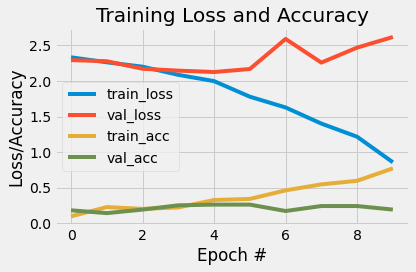

In [49]:
plot_history(H,10)

### Predictions

In [56]:
predictions = model.predict(testX)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

              precision    recall  f1-score   support

     Cezanne       0.00      0.00      0.00        10
       Degas       0.57      0.40      0.47        10
     Gauguin       0.36      0.50      0.42        10
      Hassam       0.00      0.00      0.00        10
     Matisse       0.00      0.00      0.00        10
       Monet       0.13      0.80      0.23        10
    Pissarro       0.00      0.00      0.00        10
      Renoir       0.07      0.10      0.08        10
     Sargent       1.00      0.10      0.18        10
     VanGogh       0.00      0.00      0.00        10

    accuracy                           0.19       100
   macro avg       0.21      0.19      0.14       100
weighted avg       0.21      0.19      0.14       100



/work/meme/cds-visual/cv101/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/work/meme/cds-visual/cv101/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/work/meme/cds-visual/cv101/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
